In [2]:
# Modified from Andrew Ng's implementation of ResNet50, applying to particle localization

import numpy as np
import scipy.misc
import scipy.signal
from matplotlib.pyplot import imshow
%matplotlib inline

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import simulation

### Set up simulation environment

In [3]:
read_noise_SD = 5000

In [4]:
sim_env = simulation.simulation_environment(length_of_chip = 256, 
                                            read_noise = read_noise_SD, 
                                            add_shot_noise_flag = True, 
                                            add_EM_gain_noise = False, 
                                            exposure_time = np.ones((3,3)),
                                            binning_sequence = [1, 32, 64], 
                                            num_of_samples = 32,
#                                             num_of_samples = 1,
                                            normalization = 100000, 
                                            target_size = 32,
                                            num_of_disks = 4,
                                            disk_intensity = 32**2
                                           )

sim_env.generate_simulation_data()

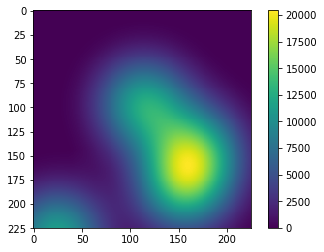

In [6]:
import matplotlib.pyplot as plt
plt.imshow(sim_env.train_y[0,:,:])
plt.colorbar()
plt.show()

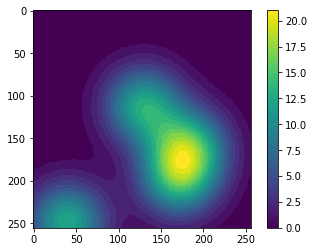

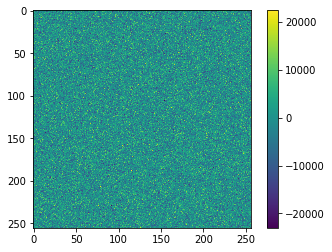

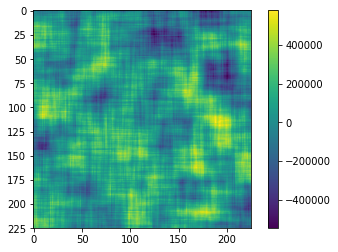

In [7]:
index = 0;

import matplotlib.pyplot as plt
plt.imshow(sim_env.GT[index,:,:])
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(sim_env.single_pixel_bin_data[index])
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(scipy.signal.convolve(sim_env.single_pixel_bin_data[index], np.ones((sim_env.target_size,sim_env.target_size)),
                                mode='valid', method='direct'))
plt.colorbar()
plt.show()

### Functions for the residual network

In [6]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block.
    
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [7]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [8]:
from keras import metrics

In [9]:
def ResNet50(input_shape = (256, 256, len(sim_env.binning_sequence)**2)):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 2
    width_2 = 128
    channel_2 = 16
    X = convolutional_block(X_input, f = 3, filters = [width_2, width_2, channel_2], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [width_2, width_2, channel_2], stage=2, block='b')
    X = identity_block(X, 3, [width_2, width_2, channel_2], stage=2, block='c')

    # Stage 3
    width_3 = 64
    channel_3 = 32
    X = convolutional_block(X, f = 3, filters = [width_3, width_3, channel_3], stage = 3, block='a', s = 1)
    X = identity_block(X, 3, [width_3, width_3, channel_3], stage=3, block='b')
    X = identity_block(X, 3, [width_3, width_3, channel_3], stage=3, block='c')
    X = identity_block(X, 3, [width_3, width_3, channel_3], stage=3, block='d')

    # Stage 4
    width_4 = 32
    channel_4 = 64
    X = convolutional_block(X, f = 3, filters = [width_4, width_4, channel_4], stage = 4, block='a', s = 1)
    X = identity_block(X, 3, [width_4, width_4, channel_4], stage=4, block='b')
    X = identity_block(X, 3, [width_4, width_4, channel_4], stage=4, block='c')
    X = identity_block(X, 3, [width_4, width_4, channel_4], stage=4, block='d')
    
    X = Conv2D(filters = 1, kernel_size = (32, 32), strides = (1,1), padding = 'valid', name = 'final', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

model = ResNet50(input_shape = (256, 256, len(sim_env.binning_sequence)**2))
# model = ResNet50(input_shape = (256, 256, len(sim_env.binning_sequence)**2))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.mse])

In [5]:
model.fit(sim_env.train_X, sim_env.train_y.reshape((*sim_env.train_y.shape, 1))
          , epochs = 1000, batch_size = 4)

In [11]:
# model.save('256_1000_True_False_npones3_3_B1_32_64B_32_100000_32_4_32p2_model')

Let's see how this model (trained on only two epochs) performs on the test set.

In [12]:
model.predict(sim_env.train_X[0:1,:,:,:]).shape

(1, 225, 225, 1)

In [13]:
import copy
train_sim_env = copy.deepcopy(sim_env)

In [19]:
test_sim_env = simulation.simulation_environment(length_of_chip = 256, 
                                            read_noise = read_noise_SD, 
                                            add_shot_noise_flag = True, 
                                            add_EM_gain_noise = False, 
                                            exposure_time = np.ones((3,3)),
                                            binning_sequence = [1, 32, 64], 
                                            num_of_samples = 8,
                                            normalization = 100000, 
                                            target_size = 32,
                                            num_of_disks = 4,
                                            disk_intensity = 32**2
                                           )

test_sim_env.generate_simulation_data()

In [20]:
import os
os.getcwd()

'C:\\Users\\matth\\gitfolder\\Camera_Noise_Analysis'

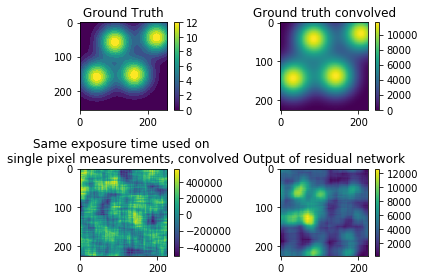

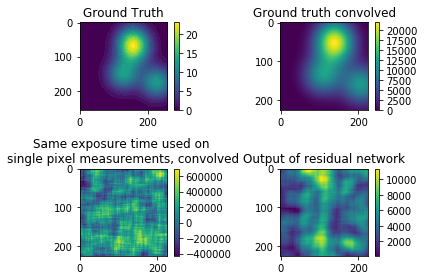

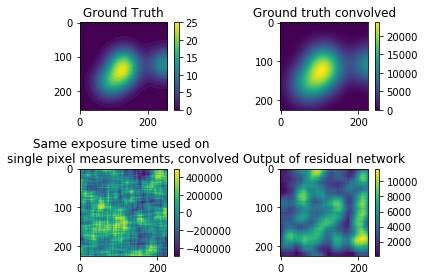

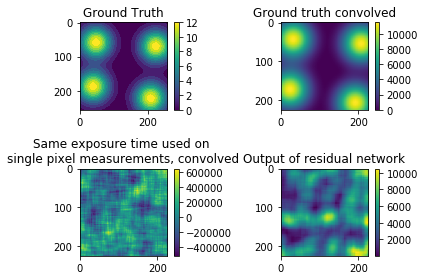

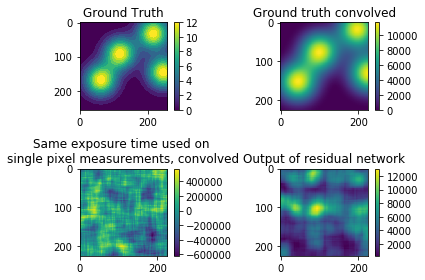

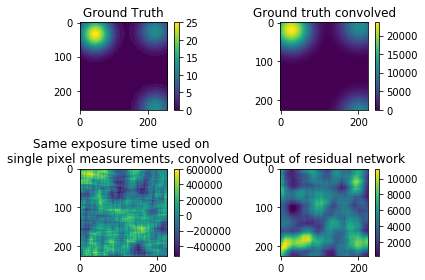

In [21]:
for index in range(0,6):

    fig, axes = plt.subplots(nrows=2, ncols=2)

    im1 = axes[0,0].imshow(test_sim_env.GT[index,:,:])
    fig.colorbar(im1, ax=axes[0,0])
    axes[0,0].set_title('Ground Truth')
    
    im4=axes[0,1].imshow(test_sim_env.train_y[index,:,:])
    fig.colorbar(im4, ax=axes[0,1])
    axes[0,1].set_title('Ground truth convolved')

    im2 = axes[1,1].imshow(model.predict(test_sim_env.train_X[index:index+1,:,:,:])[0,:,:,0])
    fig.colorbar(im2, ax=axes[1,1])
    axes[1,1].set_title('Output of residual network')

    image = scipy.signal.convolve(
        test_sim_env.single_pixel_bin_data[index,:,:], 
        np.ones((test_sim_env.target_size,test_sim_env.target_size)),mode='valid', method='direct')
    im3=axes[1,0].imshow(image)
    fig.colorbar(im3, ax=axes[1,0])
    axes[1,0].set_title('Same exposure time used on \nsingle pixel measurements, convolved')

    
    plt.tight_layout()
    plt.savefig('residual_network_on_binned_vs_single_pixel_{}.jpg'.format(index), dpi=1000)
    plt.show()

In [17]:
assert 1==2

AssertionError: 

### Obsolete Code

In [ ]:
plt.imshow(model.predict(sim_env.train_X[10:11,:,:,:])[0,:,:,0])
plt.colorbar()

In [ ]:
plt.imshow(sim_env.train_y[10,:,:])
plt.colorbar()

In [ ]:
sim_env.train_X.shape

### References 

This notebook presents the ResNet algorithm due to He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the github repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's github repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
